<h1><center> Median Income and Venues in Istanbul </center></h1>

![alt text](https://www.internationalinvestment.net/api/v1/wps/c6e67f4/943651e2-c0c5-484d-a00f-03055a68eb6a/3/Istanbul-Turkey-580x358.jpg)


## Introduction
Istanbul (or Constantinople? To reference an American joke) is one of the largest cities/metropolitan areas in South Eastern Europe/South Western Asia with over 15,000,000 people. Due to numerous issues with finding suitable data using foursquare I used Istanbul due to the robust data found within foursquare api for the city. 

Istanbul is a city with a dense population, with nearly 7 people per square mile. In addition to this there is a wide disparity in median income within each of the 39 districts found in Istanbul. The median income in Istanbul is ~31K TR, however the median income between districts varies from 13-47K. 

With such a densely populated city, relatively high level of income and growing economy we are going to try and use median income as a base parameter for choosing a venue(s) to invest in.

## Problem To Solve
An investor looking to build an entertainment venue in Istanbul would want the median income to be high but also want current venues to be unpopular or not be in the top 3 of popularity. We ideally want to look for high "MedIncome" and also popular venues such as parks or forests over Cafes or Restaurants. We do not want to compete with established and popular venues. 

## Data Description
To consider the problem we can list the datas as belows

 - I found the Second-level Administrative Divisions of the Turkey from Spatial Data Repository of NYU [1]. The .json file has coordinates of the all city of Turkey.
 - I used Forsquare API to get the most common venues of a given Borough in Istanbul [2].
 - There isn't much public demographic data and social parameters for the city of Istanbul. I collected median income using google search for districts it was available then I created a variable to estimate the median income for districts that weren't listed. The standard median income is roughly 5.6-6.2x the average home price. [3].
 - I used Google Maps, 'Search Nearby' option to get the center coordinates of the each Borough. [4].
 
 


### Importing libraries and GitHub .csv file to data frame

In [1]:
import pandas as pd 
import numpy as np
import requests

url = 'https://raw.githubusercontent.com/PhilMStudy/Coursera_Capstone/master/Istanbul.csv'

df = pd.read_csv(url)

df.head()

,Borough,MedIncome,Latitude,Longitude
0,Adalar,47034,40.8619,29.1208
1,Arnavutkoy,13540,41.1956,28.7352
2,Atasehir,33405,40.9831,29.1279
3,Avcilar,14689,40.9880,28.7170
4,Bagcilar,19560,41.0450,28.8338


### Importing Visualization and Clustering Libraries

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


### Importing Folium and Nominatim

In [3]:
import os
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # Converts Addresses into Lat/Long Values
import csv
from urllib.request import urlopen

!pip install folium

import folium #Map library

print('Libraries Imported')

Libraries Imported


In [4]:
!pip install yellowbrick
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
print('Libraries Imported.')

Libraries Imported.


### Using Geopy to find geocoordinates of Istanbul

In [5]:
address = 'Istanbul, TR'

geolocator = Nominatim(user_agent="philmstudy")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Istanbul are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Istanbul are 41.0096334, 28.9651646.


### Folium map created with markers reflecting Districts (Boroughs) in Istanbul

In [6]:
map_Istan = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_Istan)  
    
map_Istan

### Four Square Credentials

In [7]:
CLIENT_ID = 'JIIKM3XY3W5FTI154R0GYKT3G53UD455Q0G40BKO3RUCDCU5' # my Foursquare ID
CLIENT_SECRET = 'CUOAVLMASPH3RXNTYDVQ5COAGS3ZUKO21JGDAYEKUFQENG45' # my Foursquare Secret
VERSION = '20190605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JIIKM3XY3W5FTI154R0GYKT3G53UD455Q0G40BKO3RUCDCU5
CLIENT_SECRET:CUOAVLMASPH3RXNTYDVQ5COAGS3ZUKO21JGDAYEKUFQENG45


### Utilizing FourSquare to find Latitude and Longitude for each District in Istanbul

In [8]:
Istan_data = df

borough_latitude = Istan_data.loc[0, 'Latitude'] # neighborhood latitude value
borough_longitude = Istan_data.loc[0, 'Longitude'] # neighborhood longitude value

borough_name = Istan_data.loc[0, 'Borough'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(borough_name, 
                                                               borough_latitude, 
                                                               borough_longitude))

Latitude and longitude values of Adalar are 40.8619, 29.1208.


### We want a limit of 500 venues within a radius of 500 meters of each borough

In [9]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    borough_latitude, 
    borough_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=JIIKM3XY3W5FTI154R0GYKT3G53UD455Q0G40BKO3RUCDCU5&client_secret=CUOAVLMASPH3RXNTYDVQ5COAGS3ZUKO21JGDAYEKUFQENG45&v=20190605&ll=40.8619,29.1208&radius=500&limit=100'

In [10]:
results = requests.get(url).json()

### Extract Category of each Venue

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Cleaning and Structuring Pandas Data Frame

In [12]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Büyükada Tepesi,Mountain,40.861107,29.117418
1,Eski Rum Yetimhanesi,Historic Site,40.861705,29.123323
2,Aşıklar butik by şükrü,Hotel,40.862570,29.118003
3,Büyükada Bisiklet Parkuru,Bike Trail,40.865000,29.116861
4,Nizam Butik Otel & Bistro,Bed & Breakfast,40.863322,29.116257


### Number of Venues Returned by FourSquare

In [13]:
print('{} venues were returned by FourSquare.'.format(nearby_venues.shape[0]))

13 venues were returned by FourSquare.


### Exploring the Boroughs within Istanbul

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Creating Function to combine venues and Boroughs into one Data Frame

In [15]:
Istan_venues = getNearbyVenues(names=Istan_data['Borough'],
                                   latitudes=Istan_data['Latitude'],
                                   longitudes=Istan_data['Longitude']
                                  )

Adalar
Arnavutkoy
Atasehir
Avcilar
Bagcilar
Bahcelievler
Bakirkoy
Basaksehir
Bayrampasa
Besiktas
Beykoz
Beylikduzu
Beyoglu
BuyukCekmece
Catalca
Cekmekoy
Esenler
Esenyurt
Eyup
Fatih
Gaziosmanpasa
Gungoren
Kadikoy
Kagithane
Kartal
KuCukCekmece
Maltepe
Pendik
Sancaktepe
Sariyer
Silivri
Sultanbeyli
Sultangazi
Sile
Sisli
Tuzla
Umraniye
Uskudar
Zeytinburnu


### Size of Newly Created Data Frame

In [16]:
print(Istan_venues.shape)
Istan_venues.head()

(1856, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adalar,40.8619,29.1208,Büyükada Tepesi,40.861107,29.117418,Mountain
1,Adalar,40.8619,29.1208,Eski Rum Yetimhanesi,40.861705,29.123323,Historic Site
2,Adalar,40.8619,29.1208,Aşıklar butik by şükrü,40.862570,29.118003,Hotel
3,Adalar,40.8619,29.1208,Büyükada Bisiklet Parkuru,40.865000,29.116861,Bike Trail
4,Adalar,40.8619,29.1208,Nizam Butik Otel & Bistro,40.863322,29.116257,Bed & Breakfast


### Number of Venues per District/Borough

In [17]:
summary = Istan_venues.groupby('Borough').count().reset_index()
summary['Count'] = summary['Venue']
summary = summary.drop(['Borough Latitude', 'Borough Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
summary = summary.sort_values('Count').reset_index(drop=True)
summary.head(40)

,Borough,Count
0,Pendik,9
1,Arnavutkoy,12
2,Adalar,13
3,BuyukCekmece,14
4,Tuzla,15
5,Beylikduzu,15
6,Sultangazi,22
7,Cekmekoy,24
8,Basaksehir,25
9,Esenyurt,25


### Bar Chart of Number of Venues per Borough

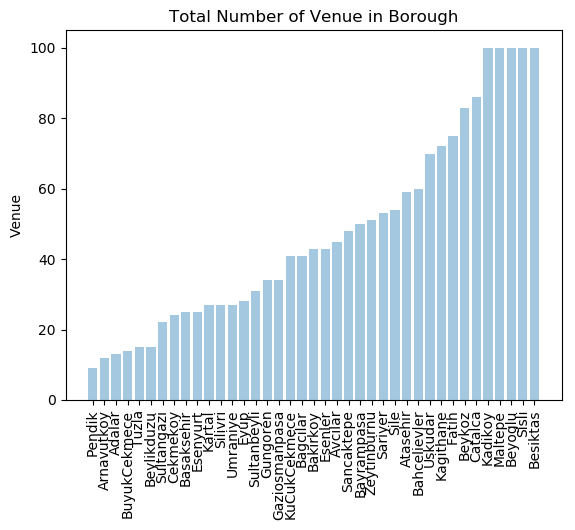

In [18]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = summary.Borough
y_pos = np.arange(len(objects))
performance = summary.Count

plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('Total Number of Venue in Borough')
plt.xticks(rotation=90)

plt.show()

    Kadikoy, Maltepe, Beyoglu, Besiktas, Sisli and Fatih each met the 100 limit of venues. Pendik, Arnavutkoy, Tuzla, Adalar, Buyukcekmece, Sultangazi, Cekmekoy, Beylikduzu, Sultangazi boroughs have less than 20 venues in our given coordinates with Latitude and Longitude.

    We did not find all venues in each borough. The results depend on the Latitude and Longitude and for this analysis we only used a single Latitude and Longitude coordinate pair for each borough. We can increase the possibilities with Neighborhood informations with more Latitude and Longitude coordinates.


### Number of Unique Categories

In [19]:
print('There are {} uniques categories.'.format(len(Istan_venues['Venue Category'].unique())))

There are 249 uniques categories.


### Analyzing each District using Venue data returned from FourSquare

In [20]:
# one hot encoding
Istanbul_onehot = pd.get_dummies(Istan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Istanbul_onehot['Borough'] = Istan_venues['Borough'] 

# move neighborhood column to the first column
list_column = Istanbul_onehot.columns.tolist()
number_column = int(list_column.index('Borough'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
Istanbul_onehot = Istanbul_onehot[list_column]

Istanbul_onehot.head()

,Borough,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,Bed & Breakfast,Beer Bar,Beer Garden,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Center,Business Service,Cafeteria,Café,Camera Store,Candy Store,Car Wash,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cigkofte Place,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Classroom,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Football Stadium,Forest,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,General Travel,Gift Shop,Gozleme Place,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indie Movie Theater,Insurance Office,Italian Restaurant,Jewelry Store,Kebab Restaurant,Kids Store,Kofte Place,Kokoreç Restaurant,Leather Goods Store,Lighthouse,Lounge,Manti Place,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mosque,Motorcycle Shop,Mountain,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Night Market,Nightclub,Non-Profit,Noodle House,Notary,Opera House,Optical Shop,Other Event,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Café,Pharmacy,Pide Place,Pilavcı,Pizza Place,Plaza,Pool,Pool Hall,Pub,Public Art,Racetrack,Radio Station,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Stationery Store,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Track,Trail,Tram Station,Tree,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Volleyball Court,Water Park,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Grouping rows by borough and the mean of the frequency of occurrence for each category

In [21]:
Istan_grouped = Istanbul_onehot.groupby('Borough').mean().reset_index()
Istan_grouped.head()

,Borough,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,Bed & Breakfast,Beer Bar,Beer Garden,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Center,Business Service,Cafeteria,Café,Camera Store,Candy Store,Car Wash,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cigkofte Place,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Classroom,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Football Stadium,Forest,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,General Travel,Gift Shop,Gozleme Place,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indie Movie Theater,Insurance Office,Italian Restaurant,Jewelry Store,Kebab Restaurant,Kids Store,Kofte Place,Kokoreç Restaurant,Leather Goods Store,Lighthouse,Lounge,Manti Place,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mosque,Motorcycle Shop,Mountain,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Night Market,Nightclub,Non-Profit,Noodle House,Notary,Opera House,Optical Shop,Other Event,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Café,Pharmacy,Pide Place,Pilavcı,Pizza Place,Plaza,Pool,Pool Hall,Pub,Public Art,Racetrack,Radio Station,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Stationery Store,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Track,Trail,Tram Station,Tree,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Volleyball Court,Water Park,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,Adalar,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.076923,0.0,0.0,0.0,0.00000,0.0,0.0,0.076923,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.153846,0.0,

### Sort Venues in Descending Order

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### New Pandas Data Frame with Top 5 Venues for each District/Borough

In [23]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = Istan_grouped['Borough']

for ind in np.arange(Istan_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Istan_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted.head(35)

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adalar,Forest,Café,Hotel,Road,Bike Trail
1,Arnavutkoy,Shopping Mall,Halal Restaurant,Pharmacy,Breakfast Spot,Restaurant
2,Atasehir,Café,Pool,Coffee Shop,Clothing Store,Park
3,Avcilar,Café,Pizza Place,Turkish Restaurant,Coffee Shop,Food Court
4,Bagcilar,Café,Turkish Restaurant,Pizza Place,Kebab Restaurant,Plaza
5,Bahcelievler,Turkish Restaurant,Café,Kebab Restaurant,Dessert Shop,Bakery
6,Bakirkoy,Gym,Café,Turkish Restaurant,Bakery,Tea Room
7,Basaksehir,Café,Gym,Bakery,Dessert Shop,Restaurant
8,Bayrampasa,Clothing Store,Restaurant,Sporting Goods Shop,Cosmetics Shop,Shopping Mall
9,Besiktas,Coffee Shop,Café,Pub,Burger Joint,Turkish Restaurant


### Using K-Means to analyze districts into 3 clusters

In [24]:
# set number of clusters
kclusters = 3

Istan_grouped_clustering = Istan_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Istan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 1, 1], dtype=int32)

### Creating Graph to show optimal number of clusters to create

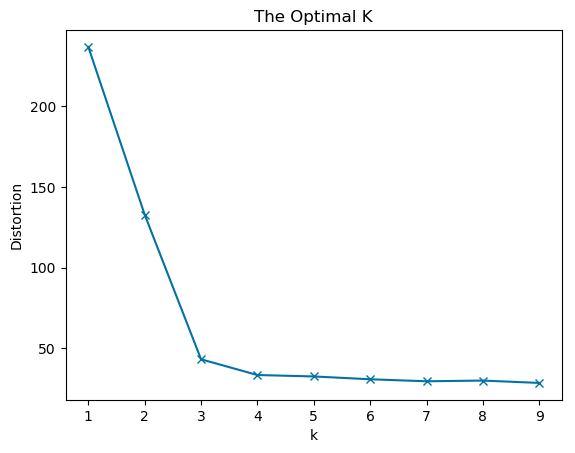

In [25]:
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(Istan_grouped_clustering)
    #kmeanModel.fit(istanbul_grouped_clustering)
    distortions.append(sum(np.min(cdist(Istan_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / Istan_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Optimal K')
plt.show()

### Pandas Data Frame merging Clusters and Top 5 Venues

In [26]:
Istan_merged = Istan_data

# add clustering labels
Istan_merged['Cluster Labels'] = kmeans.labels_

# merge SantaFe_grouped with SantaFe_data to add latitude/longitude for each neighborhood
Istan_merged = Istan_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')

Istan_merged.head() # check the last columns!

,Borough,MedIncome,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adalar,47034,40.8619,29.1208,2,Forest,Café,Hotel,Road,Bike Trail
1,Arnavutkoy,13540,41.1956,28.7352,2,Shopping Mall,Halal Restaurant,Pharmacy,Breakfast Spot,Restaurant
2,Atasehir,33405,40.9831,29.1279,2,Café,Pool,Coffee Shop,Clothing Store,Park
3,Avcilar,14689,40.9880,28.7170,0,Café,Pizza Place,Turkish Restaurant,Coffee Shop,Food Court
4,Bagcilar,19560,41.0450,28.8338,2,Café,Turkish Restaurant,Pizza Place,Kebab Restaurant,Plaza


### Creating Bar Chart for Most Common Venue

In [27]:
count_venue = Istan_merged
count_venue = count_venue.drop(['Borough','MedIncome', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Breakfast Spot,Café,Clothing Store,Coffee Shop,Forest,Gym,Hotel,Kebab Restaurant,Seafood Restaurant,Shopping Mall,Steakhouse,Turkish Restaurant
0,0,2,0,0,0,0,0,0,0,0,0,0
1,0,15,0,1,0,0,0,1,0,0,0,0
2,1,7,2,0,1,1,1,0,1,1,2,3


### Bar Chart Output

Text(0, 0.5, 'Clusters')

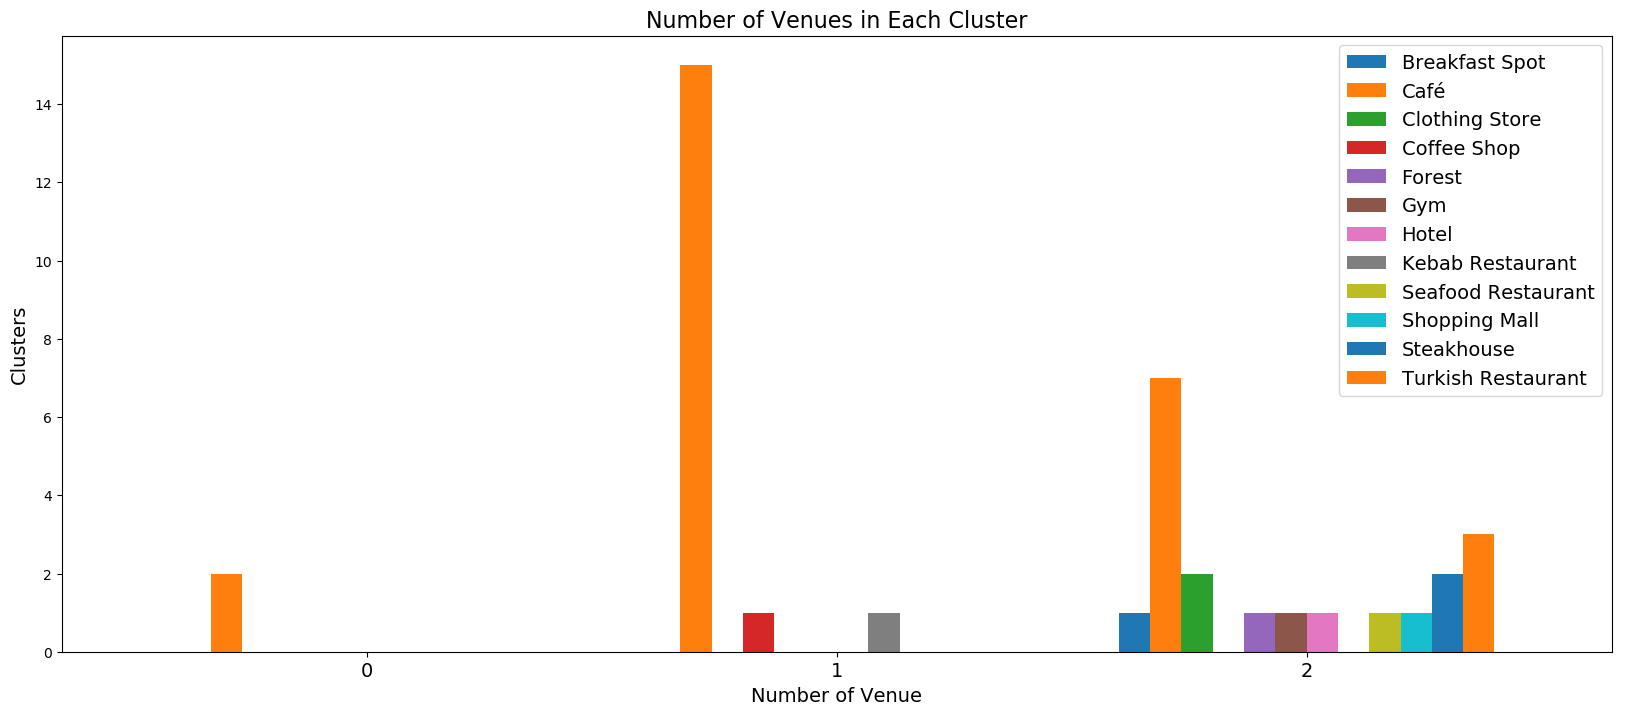

In [28]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)

### Labeling Clsuters to Reflect Bar Chart Above

In [29]:
Cluster_labels = {'Clusters': [0,1,2], 'Labels': ["Cafe Venues","Multiple Social Venues","Accommodation & Intensive Cafe Venues"]}
Cluster_labels = pd.DataFrame(data=Cluster_labels)
Cluster_labels

,Clusters,Labels
0,0,Cafe Venues
1,1,Multiple Social Venues
2,2,Accommodation & Intensive Cafe Venues


### Creating New Lables Reflecting Median Income Clusters

In [30]:
data_process = df.sort_values('MedIncome').reset_index(drop=True)
data_process = data_process.drop(['Latitude', 'Longitude'], axis=1)
data_process.head()

,Borough,MedIncome,Cluster Labels
0,Arnavutkoy,13540,2
1,Catalca,14400,1
2,Avcilar,14689,0
3,Beylikduzu,16704,2
4,Silivri,17490,2


### Average Income Histogram

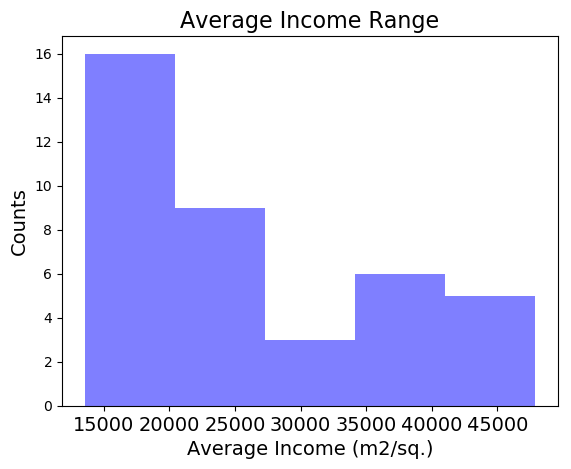

In [31]:
num_bins = 5
n, bins, patches = plt.hist(data_process['MedIncome'], num_bins, facecolor='blue', alpha=0.5)
plt.title("Average Income Range",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Average Income (m2/sq.)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

### We can Define Ranges as Follows:
 - Low Level Income <15000
 - Mid-1 Level Income 15,000 - <20,000
 - Mid-2 Level Income 20,000 - <25,000
 - High-1 Level Income 25,000 - <30,000
 - High-2 Level Income 30,000+

In [32]:
level = []
for i in range(0,len(data_process)):
    if (data_process['MedIncome'][i] < 15000):
        level.append("Low Level Income")
    elif (data_process['MedIncome'][i] >= 15000 and data_process['MedIncome'][i] < 20000):
        level.append("Mid-1 Level Income")
    elif (data_process['MedIncome'][i] >= 20000 and data_process['MedIncome'][i] < 25000):
        level.append("Mid-2 Level Income")
    elif (data_process['MedIncome'][i] >= 25000 and data_process['MedIncome'][i] < 30000):
        level.append("High-1 Level Income")
    else:
        level.append("High-2 Level Income")   

data_process['Income_Clusters'] = level
data_process.head(40)

,Borough,MedIncome,Cluster Labels,Income_Clusters
0,Arnavutkoy,13540,2,Low Level Income
1,Catalca,14400,1,Low Level Income
2,Avcilar,14689,0,Low Level Income
3,Beylikduzu,16704,2,Mid-1 Level Income
4,Silivri,17490,2,Mid-1 Level Income
5,Esenler,17840,1,Mid-1 Level Income
6,BuyukCekmece,18000,2,Mid-1 Level Income
7,Cekmekoy,18120,1,Mid-1 Level Income
8,Bahcelievler,18294,2,Mid-1 Level Income
9,Gungoren,18340,2,Mid-1 Level Income


### We want to show the top 3 venues to our investor for each district

In [33]:
top3 = Istan_venues.groupby(['Borough','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['Borough','Counts'],ascending=False).groupby('Borough').head(3).reset_index(drop=True)

top3['Top_3'] = top3['Counts'].map(str) + " " + top3['Venue Category']
top3 = top3.groupby(['Borough'])['Top_3'].apply(", ".join).reset_index()

top3.head()

,Borough,Top_3
0,Adalar,"2 Café, 2 Forest, 1 Bed & Breakfast"
1,Arnavutkoy,"2 Shopping Mall, 1 Arcade, 1 Breakfast Spot"
2,Atasehir,"5 Café, 4 Pool, 3 Coffee Shop"
3,Avcilar,"19 Café, 2 Coffee Shop, 2 Pizza Place"
4,Bagcilar,"5 Café, 3 Turkish Restaurant, 2 Auto Garage"


## Results

### Main Data Frame joing/merging all existing data frames

In [34]:
import numpy as np

result = pd.merge(Istan_merged, 
                    top3[['Borough', 'Top_3']],
                    left_on = 'Borough',
                    right_on = 'Borough',
                    how = 'left')
result= pd.merge(result, 
                    Cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')
result = pd.merge(result, 
                    data_process[['Borough', 'Income_Clusters']],
                    left_on = 'Borough',
                    right_on = 'Borough',
                    how = 'left')

result = result.drop(['Clusters'], axis=1)
result.head(40)

,Borough,MedIncome,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Top_3,Labels,Income_Clusters
0,Adalar,47034,40.8619,29.1208,2,Forest,Café,Hotel,Road,Bike Trail,"2 Café, 2 Forest, 1 Bed & Breakfast",Accommodation & Intensive Cafe Venues,High-2 Level Income
1,Arnavutkoy,13540,41.1956,28.7352,2,Shopping Mall,Halal Restaurant,Pharmacy,Breakfast Spot,Restaurant,"2 Shopping Mall, 1 Arcade, 1 Breakfast Spot",Accommodation & Intensive Cafe Venues,Low Level Income
2,Atasehir,33405,40.9831,29.1279,2,Café,Pool,Coffee Shop,Clothing Store,Park,"5 Café, 4 Pool, 3 Coffee Shop",Accommodation & Intensive Cafe Venues,High-2 Level Income
3,Avcilar,14689,40.9880,28.7170,0,Café,Pizza Place,Turkish Restaurant,Coffee Shop,Food Court,"19 Café, 2 Coffee Shop, 2 Pizza Place",Cafe Venues,Low Level Income
4,Bagcilar,19560,41.0450,28.8338,2,Café,Turkish Restaurant,Pizza Place,Kebab Restaurant,Plaza,"5 Café, 3 Turkish Restaurant, 2 Auto Garage",Accommodation & Intensive Cafe Venues,Mid-1 Level Income
5,Bahcelievler,18294,40.9976,28.8500,2,Turkish Restaurant,Café,Kebab Restaurant,Dessert Shop,Bakery,"8 Turkish Restaurant, 5 Café, 4 Kebab Restaurant",Accommodation & Intensive Cafe Venues,Mid-1 Level Income
6,Bakirkoy,45200,40.9835,28.8679,2,Gym,Café,Turkish Restaurant,Bakery,Tea Room,"3 Café, 3 Gym, 3 Turkish Restaurant",Accommodation & Intensive Cafe Venues,High-2 Level Income
7,Basaksehir,19200,41.0969,28.7718,1,Café,Gym,Bakery,Dessert Shop,Restaurant,"7 Café, 2 Bakery, 2 Dessert Shop",Multiple Social Venues,Mid-1 Level Income
8,Bayrampasa,20902,41.0477,28.8992,2,Clothing Store,Restaurant,Sporting Goods Shop,Cosmetics Shop,Shopping Mall,"8 Clothing Store, 5 Restaurant, 5 Sporting Goo...",Accommodation & Intensive Cafe Venues,Mid-2 Level Income
9,Besiktas,47909,41.0469,29.0078,1,Coffee Shop,Café,Pub,Burger Joint,Turkish Restaurant,"19 Coffee Shop, 12 Café, 8 Pub",Multiple Social Venues,High-2 Level Income


### Visualization of Cluster Results using Folium

In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, join, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Borough'], result['Labels'], result['Top_3'], result['Cluster Labels'], result['Income_Clusters']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(join), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color= rainbow[cluster_number-1],
        popup=label,
        fill_color = rainbow[cluster_number-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

### Preparing geospatial data to use with Chloropleth. Cleaned up json file from NYU.edu reflecting all districts in Istanbul

In [36]:
!wget --quiet https://raw.githubusercontent.com/Srcanyildiz/istanbul/master/istanbul_geo_1.json -O istanbul_geo.json
    
#https://geo.nyu.edu/download/file/stanford-nj696zj1674-geojson.json    
print('GeoJSON file downloaded!')

istanbul_geo = r'istanbul_geo.json'

#San Francisco La, Lo
latitude = 41.01
longitude = 28.96028

# display Istanbul
istanbul_map = folium.Map(location=[latitude, longitude], zoom_start=10)

GeoJSON file downloaded!


<h3><center>Final Map using Chloropleth and Folium to show each district</center><h3>

#### markers contain following 
 - District
 - Cluster
 - Median Income
 - Top 3 Venues

In [37]:
istanbul_map.choropleth(
    geo_data=istanbul_geo,
    data=Istan_data,
    columns=['Borough','MedIncome'],
    key_on='feature.properties.name_2',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Median Income in Istanbul',
    highlight=True
)

markers_colors = []
for lat, lon, poi, cluster, join, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Borough'], result['Labels'], result['Top_3'], result['Cluster Labels'], result['Income_Clusters']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(join), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color= rainbow[cluster_number-1],
        fill=True,
        fill_color= rainbow[cluster_number-1],
        fill_opacity=1).add_to(istanbul_map)
   


#display map
istanbul_map

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Discussion

Istanbul is a very large, diverse and densely populated city. In addition to this the median income varies greatly from district to district. This study only looked at venues per borough/district and not by neighborhood or block. This may alter the results that others may realize when they perform their study on Istanbul. For such a large modern city we also do not have a readily identifiable source of free data to measure demographic parameters for a more detailed analysis. In a further study I would like to combine average home price and average income to locate venues nearby. 

## Conclusion

 - Clusters 0 & 2: We believe our investor should invest in a coffee shop chain and we would suggest investing in cluster regions 0 and 2. Cluster 1 region does not have a large number of coffee shops and could be expaned into at a later date, but Clusters 0 and 1 have a very low number of coffee shops and would be markets with low levels of saturation/established competitors.
 - Cluster 1: While this area does have a relatively low prevalence of coffee shops being a top 3 venue, it has established venues that are popular. We would be better off not competing directly with established competitors in their largest markets.